The objective is to calibrate parameters $\rho$ and $\alpha$ of the CES utility function:


$$u(x,T) = [\alpha T_{int}^\rho + (1 - \alpha) x^\rho ]^{1\rho}$$


We know rel

In [82]:
import os
import pandas as pd
import numpy as np

from numpy import log
from scipy.optimize import curve_fit, root
from project.model import get_inputs
from project.thermal import heat_intensity
from project.utils import reindex_mi, make_plot

## Data
Phebus 2012
Logisitic curve from Allibe 2012

In [86]:
budget = pd.Series([i / 100 for i in range(1, 50, 1)])
intensity = heat_intensity(budget)
intensity.index = budget
intensity

0.01    0.990088
0.02    0.857696
0.03    0.780253
0.04    0.725305
0.05    0.682685
0.06    0.647861
0.07    0.618419
0.08    0.592914
0.09    0.570418
0.10    0.550294
0.11    0.532090
0.12    0.515470
0.13    0.500182
0.14    0.486028
0.15    0.472850
0.16    0.460523
0.17    0.448944
0.18    0.438026
0.19    0.427700
0.20    0.417903
0.21    0.408584
0.22    0.399698
0.23    0.391208
0.24    0.383079
0.25    0.375282
0.26    0.367791
0.27    0.360583
0.28    0.353636
0.29    0.346934
0.30    0.340459
0.31    0.334196
0.32    0.328132
0.33    0.322255
0.34    0.316553
0.35    0.311016
0.36    0.305635
0.37    0.300402
0.38    0.295309
0.39    0.290347
0.40    0.285512
0.41    0.280795
0.42    0.276193
0.43    0.271698
0.44    0.267307
0.45    0.263015
0.46    0.258817
0.47    0.254709
0.48    0.250688
0.49    0.246750
dtype: float64

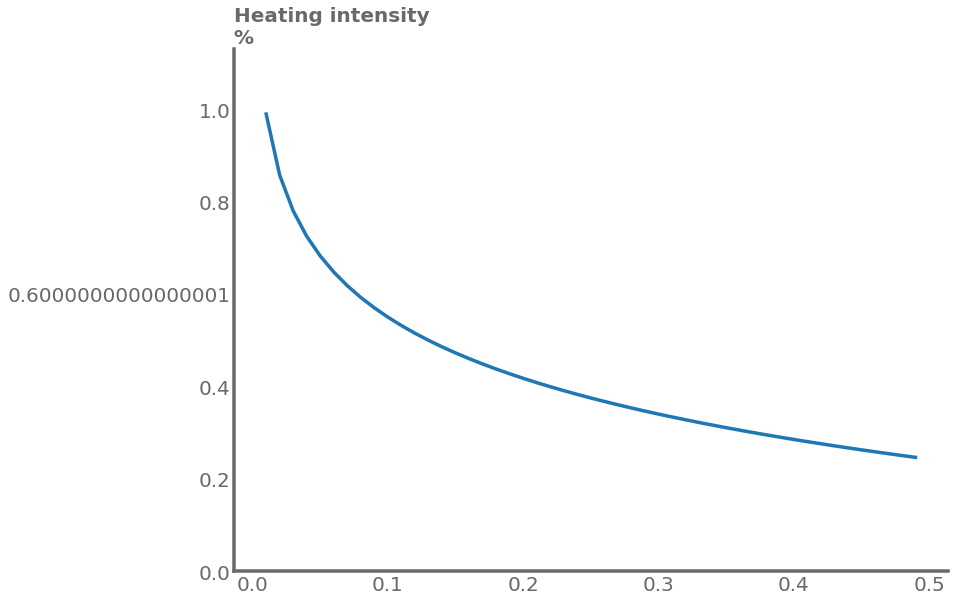

In [89]:
make_plot(intensity, 'Heating intensity (%)', integer=False, legend=False)

In [94]:
# 'buildingstock_example.csv'
resirf_inputs = get_inputs(variables=['buildings', 'income', 'energy_prices'],
                           building_stock=os.path.join('project', 'input', 'stock', 'buildingstock_sdes2018_simple_1.csv'))
buildings = resirf_inputs['buildings']
income = resirf_inputs['income']
income.index.names = ['Income tenant']
price = resirf_inputs['energy_prices'].iloc[0, :]


2022-12-27 16:38:31,234 - 70613 - log_ - INFO - Creating AgentBuildings object
2022-12-27 16:38:31,234 - 70613 - log_ - INFO - Creating AgentBuildings object


In [95]:
heat_consumption = buildings.heating_consumption() * buildings.surface
energy_bill = buildings.energy_bill(price, heat_consumption)
income = reindex_mi(income, energy_bill.index)
budget_share = energy_bill / income
heating_intensity = heat_intensity(budget_share)

In [104]:
heating_intensity.describe()

count    5880.000000
mean        0.837274
std         0.224594
min         0.266108
25%         0.671893
50%         0.832878
75%         0.999149
max         1.435302
dtype: float64

In [96]:
def demand_ces_homogenous(X, sigma):
    """Demand function derived from ces utility function.


    Represents the tradeoff between thermal comfort and energy expenditure.

    Parameters
    ----------
    X: tuple
        Income, Price
    sigma: elasticity of subsitution
    alpha

    Returns
    -------

    """
    income, energy_bill = X
    return energy_bill**(sigma - 1) * income / (energy_bill**sigma + 1)


def rho_ces(income, energy_bill, s):
    P = income / 1
    X = s / (income - energy_bill * s)
    return log(P) / log(X) + 1



In [97]:
def demand_ces_sigma(X, sigma, alpha):
    """Demand function derived from ces utility function.


    Represents the tradeoff between thermal comfort and energy expenditure.

    Parameters
    ----------
    X: tuple
        Income, Price
    sigma: elasticity of subsitution
    alpha

    Returns
    -------

    """
    income, energy_bill = X
    s = (alpha / energy_bill)**sigma * income / (alpha**sigma * energy_bill**(1 -sigma) +  (1 - alpha)**sigma)
    x = (1 - alpha)**sigma *  income / (alpha**sigma * energy_bill**(1 - sigma) + (1 - alpha)**sigma)
    return s

In [105]:
best_vals, covar = curve_fit(demand_ces_sigma, (income, energy_bill), heating_intensity, p0=(0.9, 0.1), method='dogbox', bounds=((-np.inf, 0.0001),(1, 0.9999)))
print(best_vals)
intensity_calc = demand_ces_sigma((income, energy_bill), best_vals[0], best_vals[1])

[7.33387472e-01 1.00000000e-04]


In [106]:
pd.concat((intensity_calc, heating_intensity, energy_bill), axis=1)

0  \
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows             
True     Owner-occupied   D1           D1            Multi-family  Natural gas-Performance boiler 0.1  0.2   0.1  1.6      0.237640   
                                                                   Oil fuel-Performance boiler    0.1  0.2   0.1  1.6      0.213313   
                                                                   Wood fuel-Performance boiler   0.1  0.2   0.1  1.6      0.282089   
                                                                   Electricity-Heat pump water    0.1  0.5   0.1  1.6      0.312259   
                                                                   Natural gas-Performance boiler 0.1  0.5   0.1  1.6      0.225716   
...                                                                                                                             ...   
         Social-housing   D10          D9            Single-family Natural gas-Performance boiler 2.5  2.0   0.5  3.0      0.243629   
                                                                   Oil fuel-Performance boiler    2.5  2.0   0.5  3.0      0.218653   
                                                                   Natural gas-Performance boiler 2.5  2.0   2.5  3.0      0.202735   
                                                                   Oil fuel-Performance boiler    2.5  2.0   2.5  3.0      0.181947   
                                                                   Wood fuel-Standard boiler      2.5  2.0   2.5  3.0      0.202291   

                                                                                                                                  1  \
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows             
True     Owner-occupied   D1           D1            Multi-family  Natural gas-Performance boiler 0.1  0.2   0.1  1.6      0.856926   
                                                                   Oil fuel-Performance boiler    0.1  0.2   0.1  1.6      0.828849   
                                                                   Wood fuel-Performance boiler   0.1  0.2   0.1  1.6      0.901507   
                                                                   Electricity-Heat pump water    0.1  0.5   0.1  1.6      0.927927   
                                                                   Natural gas-Performance boiler 0.1  0.5   0.1  1.6      0.843542   
...                                                                                                                             ...   
         Social-housing   D10          D9            Single-family Natural gas-Performance boiler 2.5  2.0   0.5  3.0      0.743557   
                                                                   Oil fuel-Performance boiler    2.5  2.0   0.5  3.0      0.715481   
                                                                   Natural gas-Performance boiler 2.5  2.0   2.5  3.0      0.695862   
                                                                   Oil fuel-Performance boiler    2.5  2.0   2.5  3.0      0.667785   
                                                                   Wood fuel-Standard boiler      2.5  2.0   2.5  3.0      0.695293   

                                                                                                                                     2  
Existing Occupancy status Income owner Income tenant Housing type  Heating system                 Wall Floor Roof Windows               
True     Owner-occupied   D1           D1            Multi-family  Natural gas-Performance boiler 0.1  0.2   0.1  1.6       201.411230  
                                                                   Oil fuel-Performance boiler    0.1  0.2   0.1  1.6       233.304828  
                                                                   Woo

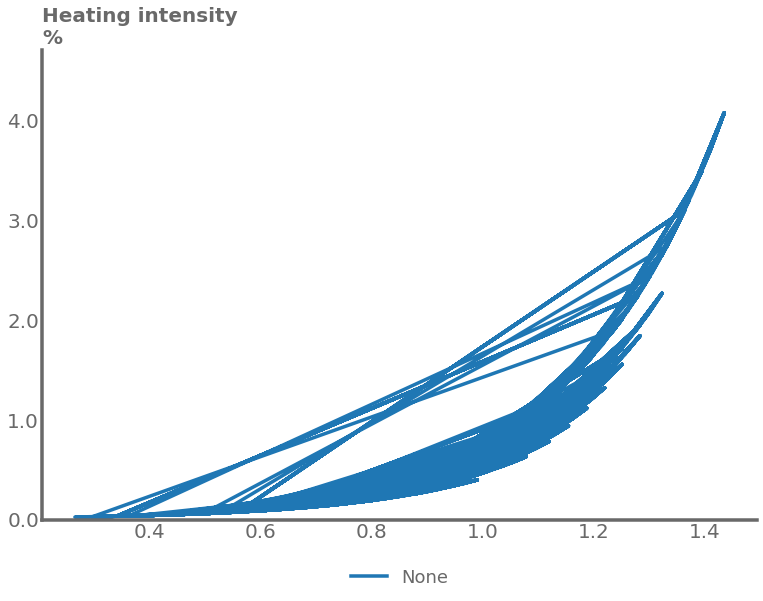

In [107]:
df = intensity_calc.copy()
df.index = heating_intensity
make_plot(df, 'Heating intensity (%)', integer=False)

Existing  Occupancy status  Income owner  Income tenant  Housing type   Heating system                  Wall  Floor  Roof  Windows
True      Owner-occupied    D1            D1             Multi-family   Natural gas-Performance boiler  0.1   0.2    0.1   1.6        0.856926
                                                                        Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.434843
                                                         Single-family  Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.241043
                                                                        Natural gas-Performance boiler  0.1   0.2    0.1   1.6        0.706972
                            D10           D10            Multi-family   Natural gas-Performance boiler  0.1   0.2    0.1   1.6        1.301570
                                                                        Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.879487
           

In [69]:
a

array([7.57826395e-01, 1.00000000e-04])

In [70]:
b

array([[3.06188160e-01, 5.96609720e-04],
       [5.96609720e-04, 1.16387919e-06]])

In [57]:
P = energy_bill / 1
X = heating_intensity / (income - energy_bill * heating_intensity)
rho = log(P) / log(X) + 1
sigma = rho / (rho - 1)
print(demand_ces_homogenous((income, energy_bill), sigma))
p0 = sigma.mean()
sigma_fit, _, _, msg, _ = curve_fit(demand_ces_homogenous, (income, energy_bill), heating_intensity, p0=p0, method='lm', full_output=True)
print(msg)
rho_fit =  sigma_fit / (sigma_fit - 1)
print(rho_fit, sigma_fit)
print(sigma_fit[0])

Existing  Occupancy status  Income owner  Income tenant  Housing type   Heating system                  Wall  Floor  Roof  Windows
True      Owner-occupied    D1            D1             Multi-family   Natural gas-Performance boiler  0.1   0.2    0.1   1.6        0.856926
                                                                        Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.434843
                                                         Single-family  Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.241043
                                                                        Natural gas-Performance boiler  0.1   0.2    0.1   1.6        0.706972
                            D10           D10            Multi-family   Natural gas-Performance boiler  0.1   0.2    0.1   1.6        1.301570
                                                                        Natural gas-Standard boiler     2.5   2.5    2.5   4.5        0.879487
           

In [ ]:
sigma

In [ ]:
s, x = demand_ces((income, energy_bill), -0.5, 0.001)
print(s, x)
print(energy_bill * s + x, income)

In [ ]:
s, x = demand_ces((income, energy_bill), 0.5, 0.1)
print(s, x)
print(energy_bill * s + x, income)

In [ ]:
heating_intensity_fit = demand_ces_homogenous((income, energy_bill), sigma_fit[0])
heating_intensity_fit

In [ ]:
pd.concat((heating_intensity, heating_intensity_fit), axis=1)

In [ ]:
demand_ces((income, energy_bill), rho_fit[0], 0.5)


In [ ]:
demand_ces((income, energy_bill), sigma_fit[0], 0.5)

In [ ]:
p0 = (0.5, 0.5)
demand_ces((income, energy_bill), p0[0], p0[1])

In [ ]:
curve_fit(demand_ces, (income, energy_bill), heating_intensity, p0=p0, method='lm', full_output=True)


In [ ]:
curve_fit(demand_ces, (income, energy_bill), heating_intensity, p0=p0, method='trf')

In [ ]:
curve_fit(demand_ces, (income, energy_bill), heating_intensity, p0=p0, method='dogbox')